# SIGNATEプラクティスコンペ

このノートブックを参照していただきありがとうございます｡  
主に､  

- ライブラリのインポート  
- データの読み込み､結合
- 最低限の前処理
- パイプラインによるモデルの訓練
- 予測
- Submit
までの流れを簡単に把握してもらえたらなぁと思います｡

## ライブラリのインポート

ここでは主に必要なライブラリをインポートをしていきます｡  

`numpy`や`pandas`を含む､必ず必要なライブラリについてはこの形式がスタンダードになります｡  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import math

import scipy as sp
from sklearn.grid_search import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_squared_log_error
%matplotlib inline

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## データの読み込み
ここではデータを読み込みをしていきます｡  
今回は`tsv`ファイルなので`pd.read_table`としています｡

In [2]:
train = pd.read_table('../input/train.tsv')
test = pd.read_table('../input/test.tsv')
ids = test['id']

In [3]:
target = train['mpg']

## 訓練､テストデータ結合
ここでは訓練データとテストデータを結合しています｡  
こうする事で､

- データの前処理を同時に行える
- データの形式が揃う為`fit`､`predict`時にエラーが出にくい

という利点があります｡

In [4]:
# merge train and test
total = pd.concat([train.drop('mpg',axis=1),test])
total.reset_index(drop=True,inplace=True)
total.reset_index(inplace=True)

## ヒストグラム
データセットの分布を簡単に確認してみます｡  
こんな簡素なプロットでも､

- `model year`,`cylinders`,`origin`,`displacement`は離散している｡
    - データ型は数値なので文字列にしてダミーに落とそう
-  `acceleration`はほぼ正規分布だ
-  `weight`は歪んだ分布で､ロングテールが見られる

という事がわかります｡

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249B6FB0BE0>,
      dtype=object)

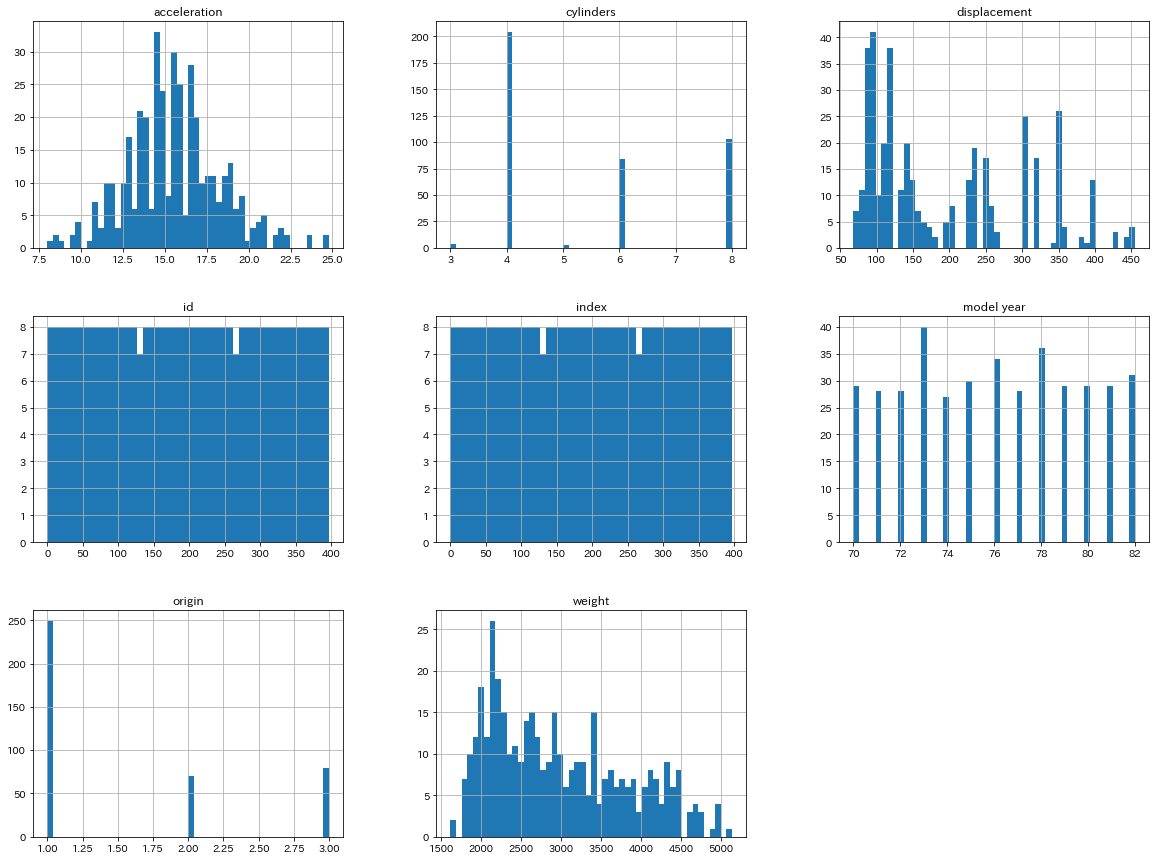

In [5]:
total.hist(bins=50,figsize=(20,15))

## 数値のアプローチ
平均や標準偏差､ローレンツ曲線(数値Ver)が確認できます｡  
例えば､

`displacement`は平均は193程度なのに最大値は455もあるので､かなり偏りがありそうです｡  
各特徴量の規模感はバラバラなのでスケーリングする必要がある

In [6]:
train.describe()

id         mpg   cylinders  displacement       weight  \
count  199.000000  199.000000  199.000000    199.000000   199.000000   
mean   200.170854   24.307035    5.296482    183.311558  2883.839196   
std    113.432759    7.797665    1.644562     98.400457   819.766870   
min      0.000000    9.000000    3.000000     71.000000  1613.000000   
25%     98.500000   18.000000    4.000000     98.000000  2217.500000   
50%    202.000000   24.000000    4.000000    140.000000  2702.000000   
75%    294.500000   30.500000    6.000000    250.000000  3426.500000   
max    396.000000   44.600000    8.000000    454.000000  5140.000000   

       acceleration  model year      origin  
count    199.000000  199.000000  199.000000  
mean      15.647739   76.165829    1.582915  
std        2.701885    3.802928    0.798932  
min        8.500000   70.000000    1.000000  
25%       14.000000   73.000000    1.000000  
50%       15.500000   76.000000    1.000000  
75%       17.150000   80.000000    2.000000  
max       23.700000   82.000000    3.000000

# 分割表
統計学で頻繁に用いられるクロス分割表を用いて､
カテゴリ変数のデータをより深く見ていきます｡

In [7]:
# mpgは取りうる値が多いので一時的におしこめる
categ = np.ceil(train['mpg'] / 7.0)
pd.crosstab(train['model year'],categ)

mpg         2.0  3.0  4.0  5.0  6.0  7.0
model year                              
70            4    6    4    0    0    0
71            4    4    7    3    0    0
72            4    3    6    0    0    0
73            4    9    2    0    0    0
74            1    3    6    4    0    0
75            1    8    5    0    0    0
76            2    4    7    1    0    0
77            0    5    5    4    0    0
78            0    9    3    4    0    1
79            0    6    3    5    0    0
80            0    1    2    9    5    2
81            0    0    5    8    5    0
82            0    0    5    7    3    0

In [8]:
# Originが何なのかよくわからないけど1が圧倒的多い
pd.crosstab(train['origin'],categ,margins=all)

mpg     2.0  3.0  4.0  5.0  6.0  7.0  All
origin                                   
1        20   53   32   14    3    0  122
2         0    3   16   13    4    2   38
3         0    2   12   18    6    1   39
All      20   58   60   45   13    3  199

In [9]:
#シリンダー数の増加と燃費には関係がありそう
pd.crosstab(train['cylinders'],categ,margins=all)

mpg        2.0  3.0  4.0  5.0  6.0  7.0  All
cylinders                                   
3            0    0    1    0    0    0    1
4            0    5   49   44   11    3  112
5            0    0    0    0    1    0    1
6            0   30    9    1    1    0   41
8           20   23    1    0    0    0   44
All         20   58   60   45   13    3  199

In [10]:
#データ処理パイプライン
fit_pipe = Pipeline([
  ('minmaxscaler',MinMaxScaler()),
  ('xgbreg',xgb.XGBRegressor(params={'colsample_bytree': 0.7184662291514716,
 'max_depth': 3,
 'subsample': 0.5130551613730331})),
])

In [11]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 10 columns):
index           398 non-null int64
id              398 non-null int64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null float64
acceleration    398 non-null float64
model year      398 non-null int64
origin          398 non-null int64
car name        398 non-null object
dtypes: float64(3), int64(5), object(2)
memory usage: 31.2+ KB


In [12]:
total['origin'] = total['origin'].astype('object')
total['model year'] = total['model year'].astype('object')
total['cylinders'] = total['cylinders'].astype('object')

total['displace_cate'] = np.ceil(total['displacement'] / 10)
total.drop('displacement',axis=1,inplace=True)
total['displace_cate'] = total['displace_cate'].astype('object')

In [13]:
total = pd.get_dummies(total)

In [14]:
train = total.query('index <= 198')
test = total.query('index > 198')

In [15]:
total.head()

index  id  weight  acceleration  cylinders_3  cylinders_4  cylinders_5  \
0      0   0  2525.0          16.0            0            1            0   
1      1   3  1925.0          14.0            0            1            0   
2      2   9  2930.0          15.5            0            0            0   
3      3  11  2125.0          14.5            0            1            0   
4      4  13  2050.0          17.3            0            1            0   

   cylinders_6  cylinders_8  horsepower_100.0         ...          \
0            0            0                 0         ...           
1            0            0                 0         ...           
2            1            0                 0         ...           
3            0            0                 0         ...           
4            0            0                 0         ...           

   displace_cate_31.0  displace_cate_32.0  displace_cate_34.0  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   displace_cate_35.0  displace_cate_36.0  displace_cate_39.0  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   displace_cate_40.0  displace_cate_43.0  displace_cate_44.0  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   displace_cate_46.0  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 453 columns]

## 訓練データの用意
ここでは説明変数と目的変数に分ける作業をします｡  
`id`や`index`で学習してしまわないようにしっかり落とします｡


In [16]:
train_X = train.drop(columns=['id','index'],axis=1)
train_y = target
test_X = test.drop(columns=['id','index'],axis=1)

In [17]:
#training
fit_pipe.fit(train_X,train_y)

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('xgbreg', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
    ...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

In [18]:
#Predict
train_y_pred = fit_pipe.predict(train_X)
test_y_pred = fit_pipe.predict(test_X)

In [19]:
train_loss = np.sqrt(mean_squared_error(train_y,train_y_pred))
print(f'train loss:{train_loss}')

train loss:1.3876273185852526


## 提出
過学習しているのは懸念事項ですが､とりあえず提出します｡  
まだ特徴量エンジニアリングや最適なパラメータ探索は行っていないですが､
悪くないスコアだと思います｡

In [20]:
result = pd.DataFrame({'index':ids,'mpg':test_y_pred})

In [21]:
result.to_csv('xgbreg.csv',header=None,index=None)